In [4]:
#Import statements
from sqlalchemy import create_engine
import cx_Oracle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display

%matplotlib inline

In [5]:
#Pyplot credentials
import plotly
plotly.tools.set_credentials_file(username='mfbeca', api_key='CXvckN91dGy1yG4ijfUX')
import plotly.plotly as py
import plotly.figure_factory as ff

In [6]:
#Connect to oracle DB

host='localhost'
port=1521
sid='springboard'
user='springboard'
password='springboard123'
sid = cx_Oracle.makedsn(host, port, sid=sid)

cstr = 'oracle://{user}:{password}@{sid}'.format(
    user=user,
    password=password,
    sid=sid
)

engine =  create_engine(
    cstr,
    convert_unicode=False,
    pool_recycle=10,
    pool_size=50,
    echo=False
)


In [12]:
#Let's continue with our preliminary analysis of the data
#First let's find out which are the most common procedures

query2 = engine.execute('SELECT HCPCS_CODE, HCPCS_DESCRIPTION, COUNT(*) '
                        'FROM MEDICARECHARGESFINAL '
                        'GROUP BY HCPCS_CODE, HCPCS_DESCRIPTION '
                        'ORDER BY COUNT(*) DESC')

df2 = pd.DataFrame(query2.fetchall())
df2.columns = query2.keys()
display(df2.head(10)) 

hcpcs_code                                  hcpcs_description  COUNT(*)
0      99213  Established patient office or other outpatient...    432107
1      99214  Established patient office or other outpatient...    396522
2      99204  New patient office or other outpatient visit, ...    172499
3      99203  New patient office or other outpatient visit, ...    169193
4      99232  Subsequent hospital inpatient care, typically ...    168455
5      G0008          Administration of influenza virus vaccine    140912
6      99212  Established patient office or other outpatient...    136629
7      99223  Initial hospital inpatient care, typically 70 ...    129439
8      99215  Established patient office or other outpatient...    114113
9      99233  Subsequent hospital inpatient care, typically ...    114086

In [11]:
#Out of the most common procedures, we will focus on 5 of them
# G0008          Administration of influenza virus vaccine
# 36415  Insertion of needle into vein for collection
# G0009             Administration of pneumococcal vaccine
# 93000  Routine EKG using at least 12 leads including
# 71020            X-ray of chest, 2 views, front and side

query3 = engine.execute('SELECT NPI,HCPCS_CODE, ST_ABBR, FIPS_CO, '
                        'AVERAGE_SUBMITTED_CHRG_AMT AS AVG_CHARGES '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE= {} '.format("'G0008'"))
df3 = pd.DataFrame(query3.fetchall())
df3.columns = query3.keys()
display(df3.head(10)) 


npi hcpcs_code st_abbr fips_co   avg_charges
0  1003000522      G0008      FL     127            73
1  1003001884      G0008      MI     049            30
2  1003002049      G0008      CA     001            31
3  1003002254      G0008      TN     179          19.4
4  1003006982      G0008      NY     085  15.025714286
5  1003004938      G0008      ME     001  22.493933333
6  1003006552      G0008      FL     105            25
7  1003007907      G0008      OR     051         27.25
8  1003008095      G0008      KY     235            45
9  1003009119      G0008      VA     107  40.155555556

C:\Users\mbeca\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



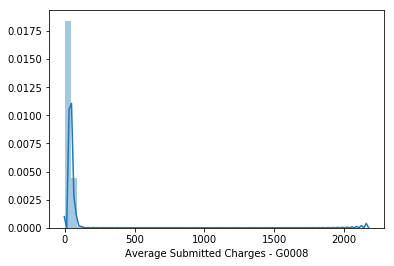

In [13]:
#Distribution plot

float_x = pd.to_numeric(df3.avg_charges, downcast='float')

x = pd.Series(float_x, name="Average Submitted Charges - G0008")
ax = sns.distplot(x)

In [18]:
#Data shows very high submitted charges
#Verifying this with new query
query4 = engine.execute('SELECT NPI,HCPCS_CODE, ST_ABBR, FIPS_CO, '
                        'AVERAGE_SUBMITTED_CHRG_AMT AS AVG_CHARGES '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE= {} '
                        'AND AVERAGE_SUBMITTED_CHRG_AMT > 250 '
                        'ORDER BY AVERAGE_SUBMITTED_CHRG_AMT DESC '.format("'G0008'"))
df4 = pd.DataFrame(query4.fetchall())
df4.columns = query4.keys()
display(df4.head(10)) 

npi hcpcs_code st_abbr fips_co   avg_charges
0  1669789129      G0008      KS     035  2172.3846452
1  1790846335      G0008      MI     103  2082.1977273
2  1841373933      G0008      WV     107  2030.4971613
3  1275840753      G0008      KS     035  1786.7261765
4  1891110615      G0008      CT     009  960.58263158
5  1437165370      G0008      CA     037  869.18518519
6  1124065461      G0008      MO     079  789.82818182
7  1518951359      G0008      MA     017  652.34707207
8  1154418218      G0008      TN     149  563.05027397
9  1760576011      G0008      LA     015        447.27

In [21]:
#Get NPI list for query

df4['npi_str'] = '\'' + df4['npi'].astype(str) + '\''
npi_list_str = df4['npi_str'].tolist()

refinedList = ','.join(a for a in npi_list_str)
refinedList

"'1669789129','1790846335','1841373933','1275840753','1891110615','1437165370','1124065461','1518951359','1154418218','1760576011','1053679860','1962846063','1114025145','1376593095','1427126226','1245577071','1902801541','1124302831','1508998840','1437263415','1952317273','1467579839','1104083450','1275544439','1821359282','1508914508'"

In [37]:
query_npi = engine.execute('SELECT NPI, NPPES_PROVIDER_LAST_ORG_NAME, '
                           'NPPES_CREDENTIALS, PROVIDER_TYPE, AVERAGE_SUBMITTED_CHRG_AMT '
                           'FROM MEDICARECHARGESFINAL '
                           'WHERE NPI IN ({}) '
                           'AND AVERAGE_SUBMITTED_CHRG_AMT > 250 '
                           'ORDER BY AVERAGE_SUBMITTED_CHRG_AMT DESC'.format(refinedList))
df_npi = pd.DataFrame(query_npi.fetchall())
df_npi.columns = query_npi.keys()
display(df_npi.head(10))

npi    nppes_provider_last_org_name nppes_credentials  \
0  1790846335                         CARLSON                MD   
1  1669789129            PRICE PHARMACIES INC              None   
2  1790846335                         CARLSON                MD   
3  1841373933               BOND'S DRUG STORE              None   
4  1275840753            PRICE PHARMACIES INC              None   
5  1891110615   HERITAGE VILLAGE PHARMACY INC              None   
6  1437165370                         BORSOOK              M.D.   
7  1124065461  SHOPKO STORES OPERATING CO LLC              None   
8  1518951359            BOUVIER PHARMACY INC              None   
9  1669789129            PRICE PHARMACIES INC              None   

                  provider_type average_submitted_chrg_amt  
0               Family Practice               2516.1393132  
1  Mass Immunizer Roster Biller               2172.3846452  
2               Family Practice               2082.1977273  
3  Mass Immunizer Roster Biller               2030.4971613  
4  Mass Immunizer Roster Biller               1786.7261765  
5  Mass Immunizer Roster Biller               960.58263158  
6               Family Practice               869.18518519  
7  Mass Immunizer Roster Biller               789.82818182  
8  Mass Immunizer Roster Biller               652.34707207  
9  Mass Immunizer Roster Biller               594.77361446

In [39]:
#Get the median of the average charges per state and plot the distribution
query5 = engine.execute('SELECT ST_ABBR, MEDIAN(AVERAGE_SUBMITTED_CHRG_AMT) AS MEDIAN_CHARGES '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE= {} '
                        'GROUP BY ST_ABBR '
                        'ORDER BY MEDIAN(AVERAGE_SUBMITTED_CHRG_AMT) DESC '.format("'G0008'"))
df5 = pd.DataFrame(query5.fetchall())
df5.columns = query5.keys()
display(df5.head(10)) 

st_abbr median_charges
0      MA             45
1      AR   36.844171691
2      NY             35
3      WA             35
4      ND             34
5      MD   31.891859597
6      NJ  31.1817299175
7      IA             31
8      CT   30.837549512
9      DC      30.279375

In [41]:
#State plot of the map

for col in df5.columns:
    df5[col] = df5[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df5['text'] = df5['st_abbr'] + '<br>' +\
            'Median charges: '+df5['median_charges']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df5['st_abbr'],
        z = df5['median_charges'].astype(float),
        locationmode = 'USA-states',
        text = df5['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Median charges per state in USD")
        ) ]

layout = dict(
        title = 'Administration of influenza virus vaccine - G0008',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mfbeca/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


C:\Users\mbeca\Continuum\anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [43]:
#Get data again for a county level choropleth map
query6 = engine.execute('SELECT ST_ABBR, FIPS_ST, FIPS_CO, '
                        'MEDIAN(AVERAGE_SUBMITTED_CHRG_AMT) AS MEDIAN_CHARGES '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE= {} ' 
                        'GROUP BY ST_ABBR, FIPS_ST, FIPS_CO '
                        'ORDER BY MEDIAN(AVERAGE_SUBMITTED_CHRG_AMT) DESC'.format("'G0008'"))
df6 = pd.DataFrame(query6.fetchall())
df6.columns = query6.keys()

display(df6.head(22)) 

st_abbr fips_st fips_co median_charges
0       AR      05     017   115.51861386
1       MA      25     019            100
2       MN      27     021  93.1789153625
3       FL      12     077   81.237307692
4       IL      17     169    79.89863354
5       SD      46     117   78.290846154
6       SD      46     017   76.611666667
7       SD      46     023          75.53
8       FL      12     067   74.724324324
9       NM      35     023             72
10      VA      51     097  71.3291090625
11      NC      37     077             71
12      SD      46     109          66.15
13      GA      13     129   66.066666667
14      NC      37     135   64.857142857
15      WI      55     103   64.144464426
16      UT      49     029   64.052631579
17      MT      30     101             63
18      MN      27     071   60.884751773
19      WI      55     113   60.513513514
20      MA      25     023             60
21      MO      29     185             60

In [46]:
df6.median_charges = df6.median_charges.astype(float)

In [50]:
display(df6.median_charges.describe())

count    2922.000000
mean       27.934467
std         7.976592
min         5.000000
25%        24.000000
50%        26.241924
75%        30.000000
max       115.518614
Name: median_charges, dtype: float64

In [51]:
df6['FIPS'] = df6['fips_st'] + df6['fips_co']
df6.median_charges = df6.median_charges.astype(float)
average_charges_series = df6.set_index('FIPS')['median_charges']
print(average_charges_series.head(25))

FIPS
05017    115.518614
25019    100.000000
27021     93.178915
12077     81.237308
17169     79.898634
46117     78.290846
46017     76.611667
46023     75.530000
12067     74.724324
35023     72.000000
51097     71.329109
37077     71.000000
46109     66.150000
13129     66.066667
37135     64.857143
55103     64.144464
49029     64.052632
30101     63.000000
27071     60.884752
55113     60.513514
25023     60.000000
29185     60.000000
31173     59.150000
46127     59.053571
31043     59.026316
Name: median_charges, dtype: float64


In [70]:
print(average_charges_series['05141'])

38.292682927


In [53]:
# Create map 
#folium example
import folium
import branca

#Add column with FIPS data
df6['FIPS'] = '0500000US' + df6['fips_st'] + df6['fips_co']
df6.median_charges = df6.median_charges.astype(float)

map_1 = folium.Map(location=[39, -96], zoom_start=4)
high_res_county_geo = "data/gz_2010_us_050_00_5m.json" 

#bins = list(df6['median_charges'].quantile([0, 0.25, 0.5, 0.75, 1]))

# from http://eric.clst.org/Stuff/USGeoJSON

# Add choropleth layer
map_1.choropleth(
 geo_data=high_res_county_geo,
 name='choropleth',
 data=df6,
 columns=['FIPS', 'median_charges'],
 key_on='properties.GEO_ID',
 fill_color='YlGnBu',
 fill_opacity=0.8,
 line_opacity=0.05,
 legend_name='Median average cost of flu shot ($)',    
 bins=5
)
folium.LayerControl().add_to(map_1)

map_1
# Save as index.html
#map_1.save('index.html')

C:\Users\mbeca\Continuum\anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.

